In [1]:
# common imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
sns.set_palette('viridis')
# working with regular expressions
import re 

import scispacy
import spacy


import gensim # topic modelling
from nltk.tokenize import word_tokenize
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords

import gensim.corpora as corpora
from gensim.models import TfidfModel

from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# visualizations
from wordcloud import WordCloud
from PIL import Image

In [2]:
# reading the dataframe-- this data represents articles focusing on leprosy research 
df = pd.read_csv("data/total_pm.csv")
df.head()

,title,abstract,journal,publication_type,language,publication_year
0,Leprosy: Clinical aspects and diagnostic techn...,"Leprosy, also known as Hansen's disease, is a ...",Journal of the American Academy of Dermatology,Journal Article,eng,2020
1,"Position statement: LEPROSY: Diagnosis, treatm...",Leprosy or Hansen's disease is a chronic infec...,Journal of the European Academy of Dermatology...,Journal Article,eng,2019
2,Leprosy in the 21st century.,Despite significant improvements in leprosy (H...,Clinical microbiology reviews,Journal Article,eng,2015
3,Neuropathies of leprosy.,Neuropathies form an integral part of the symp...,Journal of the neurological sciences,Journal Article,eng,2021
4,Leprosy.,The World Health Organization field leprosy cl...,BMJ clinical evidence,Journal Article,eng,2007


In [3]:
df['publication_year'].replace('No Data',np.NaN,inplace=True)
df['publication_year']=pd.to_numeric(df['publication_year'])

lang=[df['language'].unique()]

Publication stats

In [4]:
df['publication_type'].value_counts()

publication_type
Journal Article                      6686
Case Reports                          794
English Abstract                      434
Historical Article                    426
Letter                                419
Comparative Study                     291
Editorial                             255
Biography                             208
Comment                               158
Clinical Trial                        112
Congress                               89
News                                   37
Evaluation Study                       29
Bibliography                            8
Interview                               8
Systematic Review                       6
Address                                 6
Consensus Development Conference        5
Guideline                               4
Observational Study                     4
Introductory Journal Article            3
Meta-Analysis                           3
Clinical Trial Protocol                 3
Review           

There are different types of articles included in this data. Let's visualise the percentage of each type and publications per year.

In [5]:
pub_counts=(df['publication_type'].value_counts()/df['publication_type'].value_counts().sum())*100

In [6]:
# publication types 
fig=px.bar(y=pub_counts,x=pub_counts.index,title='Types of publication involving leprosy research')
fig.update_layout(autosize=False,
                  height=600,
                  width=1000,
                  xaxis_title=None,
                  yaxis_title="Publication counts (%)")
fig.show()

In [7]:
data_counts=df.groupby(['publication_year']).count()
data_counts.sort_values(by="title",ascending=False)

,title,abstract,journal,publication_type,language
publication_year,,,,,
1982.0,215,215,215,215,215
1986.0,201,201,201,201,201
1983.0,194,194,194,194,194
1987.0,190,190,190,190,190
1985.0,179,179,179,179,179
...,...,...,...,...,...
1949.0,39,39,39,39,39
2024.0,19,19,19,19,19
1963.0,15,15,15,15,15


In [8]:
data_counts=df.groupby(['publication_year'])['title'].count()
fig = px.line(data_counts,markers=True).update_layout(xaxis_title="Year",yaxis_title="Publications",title="Number of publications by year",
                                         showlegend=False)

fig.update_layout(plot_bgcolor='white',xaxis=dict(showline=True))

In [9]:
# publication type by year
jour_counts=df.groupby(['publication_year','publication_type'])['journal'].count()
jour_counts=jour_counts.reset_index()
fig=px.bar(df,x=jour_counts['publication_year'],y=jour_counts['journal'],barmode='stack',
           color=jour_counts['publication_type'],
           labels={'x':'Year','y':'No.of publications per year','color':'Publication type'},
           title='Publication types by year')
fig.show()

In [10]:
# subsetting the original dataframe to only include journal articles
lep_articles = df[(df['publication_type']=="Journal Article") & (df['abstract']!="No Abstract")]
lep_articles.shape

(2400, 6)

In [ ]:
# find all the abbreviations in the abstract
abbreviations = re.findall(r"\b[A-Z]{2,}\b",lep_articles['abstract'].to_string())

Data Preprocessing

In [29]:
from nltk.tokenize import word_tokenize
# preprocessing the data -- remove spaces and digits
def process(text):
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d','',text)
    return text
lep_data = lep_articles.loc[:,['title','abstract','publication_year']]
lep_data['cleaned_abstract']=lep_data['abstract'].apply(lambda x:process(x))

# tokenize and convert to lower case
def tokenize(text):
    text = word_tokenize(text)
    lowered_text =[]

    for i in text:
        if i in abbreviations:
            lowered_text.append(i)
        elif len(i)>2 and i not in abbreviations:
            lowered_text.append(i.lower())
    return lowered_text

lep_data['tokens']= lep_data['cleaned_abstract'].apply(lambda x:tokenize(x))

# defining stopwords to remove
stopwords_list = stopwords.words('english')
stopwords_list.append("leprosy")

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords_list]

lep_data['no_stopwords'] = lep_data['tokens'].apply(remove_stopwords)


In [30]:
# bigrams
bigrams = Phrases(lep_data['no_stopwords'], min_count=3, threshold=10)
lep_data['bigrams'] = lep_data['no_stopwords'].apply(lambda x:bigrams[x])
lep_data=lep_data.reset_index(drop=True)

In [31]:
lep_data.head()

,title,abstract,publication_year,cleaned_abstract,tokens,no_stopwords
0,Leprosy: Clinical aspects and diagnostic techn...,"Leprosy, also known as Hansen's disease, is a ...",2020.0,Leprosy also known as Hansens disease is a cur...,"[leprosy, also, known, hansens, disease, curab...","[also, known, hansens, disease, curable, infec..."
1,"Position statement: LEPROSY: Diagnosis, treatm...",Leprosy or Hansen's disease is a chronic infec...,2019.0,Leprosy or Hansens disease is a chronic infect...,"[leprosy, hansens, disease, chronic, infection...","[hansens, disease, chronic, infection, caused,..."
2,Leprosy in the 21st century.,Despite significant improvements in leprosy (H...,2015.0,Despite significant improvements in leprosy Ha...,"[despite, significant, improvements, leprosy, ...","[despite, significant, improvements, hansens, ..."
3,Neuropathies of leprosy.,Neuropathies form an integral part of the symp...,2021.0,Neuropathies form an integral part of the symp...,"[neuropathies, form, integral, part, the, symp...","[neuropathies, form, integral, part, symptomat..."
4,Leprosy.,The World Health Organization field leprosy cl...,2007.0,The World Health Organization field leprosy cl...,"[the, world, health, organization, field, lepr...","[world, health, organization, field, classific..."


# Tokens to vector representation 
In a simpler sense, this is just a way of representing our texts into numbers or what they like to call vector space. This makes our text data ready to be fed to LDA model or any other such model. Two popular ways of such vector representation include:
- BoW model - Bag of Words representation -- where you consider a corpus to be just a random collection of words- no consideration for order of words. Here, we are concerned with the frequencies of each unique term in the corpus across each document. And then you represent this in a form of multidimensional data where terms represent column and documents represent rows. The cell contains the number of occurences of each term in each document
- tf-idf model - this seeks to avert one of the disadvantages of bow model where as we only consider the frequencies of term, the most common words in every document that maynot even have significant contextual meaning gets more representation compared to relatively rarer words. 

In [ ]:
# BoW representation of the documents
docs = lep_data['bigrams'].to_list()
import pprint
# create dictionary
''' takes in tokenized data and counts the frequency of each term in each document of the corpus
    assigning their corresponding frequencies as unique ids to each term creating a dictionary.
'''
bow_dict=corpora.Dictionary(docs)
# term document frequency
corpus =[bow_dict.doc2bow(doc) for doc in docs]
#pprint.pprint(corpus)

#for doc in corpus:
#   print([[bow_dict[id],freq]for id, freq in doc])


In [33]:
corpus_dict ={}
for doc in corpus:
    for idx, freq in doc:
        term = bow_dict[idx] 
        if term in corpus_dict:
            corpus_dict[term] += freq
        else:
            corpus_dict[term] = freq

<Figure size 640x480 with 0 Axes>

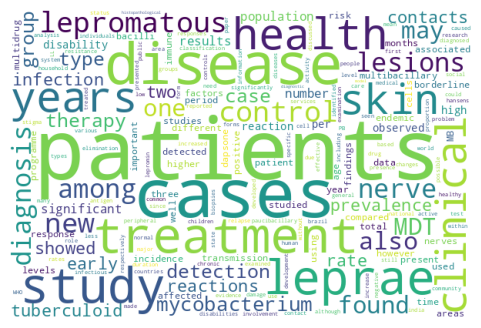

In [34]:
cloud_whole_period = WordCloud(random_state=4,background_color='white',width=600, height=400).generate_from_frequencies(corpus_dict)
plt.tight_layout()
plt.figure(figsize=(6,4) )
plt.imshow(cloud_whole_period)
plt.axis('off')
plt.show()

In [ ]:
# creating tf-idf model
tfidf = TfidfModel(corpus, smartirs='ntc') 
#for doc in tfidf[corpus]:
#   print([[bow_dict[id],wt] for id, wt in doc])    

In [37]:
# training with lda 
lda = gensim.models.ldamodel.LdaModel

Coherence Score is one of the common evaluation metric for LDA topic modelling. It is used to determine the optimal number of most  topics based on coherence(how much do words in each topic make sense together).

In [40]:
# coherence score based on the CV metric
topics = []
score = []
for i in range(1,20,1):
    lda_model = lda(
    corpus = tfidf[corpus],
    id2word=bow_dict,
    num_topics = i,
    alpha =0.1,
    eta="auto",
    passes=1,
    iterations = 50,
    random_state=42,
    eval_every =None)

    cm = CoherenceModel(model= lda_model, 
                        texts=docs,
                        corpus=tfidf[corpus], 
                        dictionary=bow_dict,
                        coherence="c_v")
    topics.append(i)
    score.append(cm.get_coherence())


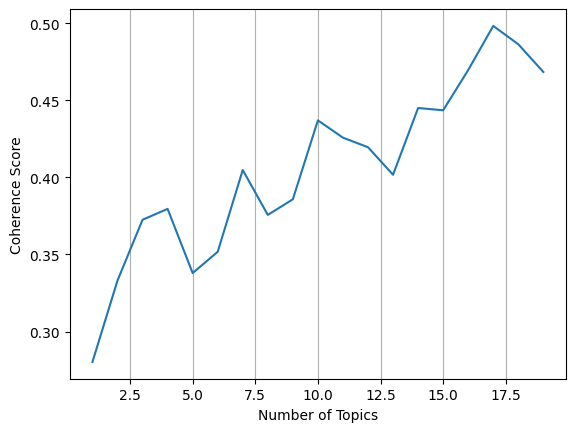

In [ ]:
plt.plot(topics, score)
plt.scatter(topics[np.argmax(score)],np.max(score),color="red")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(axis="x")
plt.show()

Hence, choosing num_topics = 17 where the coherence seems to be maximum based on above coherence score plot.

In [42]:
lda_model1 = lda(
    corpus = tfidf[corpus],
    id2word=bow_dict,
    num_topics = 17,
    alpha =0.1,
    eta="auto",
    passes=1,
    iterations = 50,
    random_state=42,
    eval_every =None)

In [55]:
lda_model1.print_topics()

[(0,
  '0.002*"susceptibility" + 0.002*"ML" + 0.002*"patients" + 0.002*"polymorphisms" + 0.002*"program" + 0.002*"MDT"'),
 (1,
  '0.003*"technique" + 0.002*"patients" + 0.002*"rheumatic" + 0.002*"stigma" + 0.002*"disease" + 0.002*"intradomiciliary"'),
 (2,
  '0.003*"nutritional" + 0.002*"mangabey" + 0.002*"ghs" + 0.002*"processed" + 0.002*"picos" + 0.002*"mediators"'),
 (3,
  '0.005*"nramp" + 0.003*"chemoprophylaxis" + 0.002*"inoculation" + 0.002*"calmetteguérin" + 0.002*"leprosin" + 0.002*"rapidity"'),
 (4,
  '0.004*"oral" + 0.003*"percent" + 0.003*"NFI" + 0.002*"snp" + 0.002*"dehabilitation" + 0.002*"scalp"'),
 (5,
  '0.004*"polymorphisms" + 0.003*"snps" + 0.003*"tlr" + 0.003*"association" + 0.002*"promoter" + 0.002*"quantify"'),
 (6,
  '0.003*"macrophages" + 0.002*"dncb" + 0.002*"poorly" + 0.002*"understood" + 0.002*"VDR" + 0.002*"respondents"'),
 (7,
  '0.003*"joint" + 0.002*"ccl" + 0.002*"deformities" + 0.002*"selfcare" + 0.002*"globulin" + 0.002*"federal"'),
 (8,
  '0.003*"psychi

In [ ]:
print("Coherence score for lda_model 1: ",CoherenceModel(model= lda_model1, 
                        texts=docs,
                        corpus=tfidf[corpus], 
                        dictionary=bow_dict,
                        coherence="c_v").get_coherence() )

Creating document-topic matrix for clustering documents together based on topics

In [ ]:
def get_vec_lda(model, corpus, k):  
    '''Create a document-topic matrix
    
    Parameters:
    model : trained LDA model
    corpus : gensim corpus
    k : number of topics

    Output:
    returns a document-topic matrix of dimension n_doc * k
    '''
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, k))
    for i in range(n_doc):
        for topic, prob in model.get_document_topics(corpus[i]):
            vec_lda[i,topic] = prob
    return vec_lda


In [ ]:
vec =get_vec_lda(lda_model1, tfidf[corpus],17)
doc_top_vec = pd.DataFrame(vec)
doc_top_vec.shape

In [ ]:
# doc-topic dataframe with assigned topic labels based on the max probabilities
doc_topic = pd.DataFrame(vec,columns=[f'Topic {i}'for i in range(17)])
doc_topic['label']=doc_topic.idxmax(axis='columns')
doc_topic['pub_date']=lep_data['publication_year']


In [ ]:
grouped_data =doc_topic.groupby(['pub_date','label'])['Topic 0'].count()
plt.figure(figsize=(10,7))
ax = sns.histplot(x = grouped_data.index.get_level_values('pub_date'),hue=grouped_data.index.get_level_values('label'),
                  weights=grouped_data.values,
                  multiple='stack',
                  binwidth=5)
plt.tight_layout()

For each topic, I calculated normalised frequency of documents i.e. number of documents published belonging to each topic per year by total number of documents published that year. This will be used to analyse any existing topic trends along these documents over the years.

In [ ]:
# normalised frequency of each topic by year
total_articles_per_year = doc_topic.groupby('pub_date')['label'].count()
num_articles_by_topic_per_year = doc_topic.groupby('pub_date')['label'].value_counts()/total_articles_per_year

# creating a dataframe
norm_freq=pd.DataFrame(num_articles_by_topic_per_year).reset_index()
norm_freq_df =  norm_freq.pivot(index='pub_date',columns='label').reset_index()
norm_freq_df.columns = norm_freq_df.columns.droplevel(0)
norm_freq_df.rename(columns={'':'pub_year'},inplace=True)

# Replacing all the NaN values with 0
norm_freq_df=norm_freq_df.fillna(0)
norm_freq_df.head()

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(18,10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(norm_freq_df['pub_year'],norm_freq_df[f'Topic {i}'])
    ax.set_title(f"Topic-{i}")
    ax.set_xlabel('Year')
    ax.grid(axis='y')
plt.tight_layout()

Mann-Kendall test is common non-parametric test used to identify any existing monotonic trends in the data.

In [ ]:
import pymannkendall as mk
trend = []
p_val = []
Z_Score = []
for col in norm_freq_df.columns[2:]:
    trend.append(mk.original_test(norm_freq_df[col]).trend)
    p_val.append(mk.original_test(norm_freq_df[col]).p)
    Z_Score.append(mk.original_test(norm_freq_df[col]).z)
cols = norm_freq_df.columns[2:].to_list()

mk_df = pd.DataFrame({
    'Topics':cols,
    'Trend': trend,
    'p_value':p_val,
    'z_Score':Z_Score
})
mk_df